In [10]:
%matplotlib inline
from Bio import motifs
import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import transforms
import matplotlib.patheffects
import matplotlib.pyplot as plt

import numpy as np

COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'T': 'darkgreen'}
bases = list(COLOR_SCHEME.keys())


In [2]:
def approximate_error(motif):
    """Calculate approximate error"""
    pwm = motif.pwm
    bases = list(pwm.keys())
    n = sum(motif.counts[bases[0]])
    approx_error = (len(bases)-1)/(2 * np.log(2) * n)
    return approx_error


def exact_error(motif):
    """Calculate exact error, using multinomial(na,nc,ng,nt)"""
    ## Super Slow. O(n^3)
    pwm = motif.pwm
    bases = list(pwm.keys())
    na = sum(motif.counts['A'])
    n = na
    nc = 0
    ng = 0
    nt = 0
    done = False
    exact_error = 0
    while not done:
        print (na,nc,ng,nt)
        exact_error += sum([-p*np.log2(p) for p in [na/n, nc/n, ng/n, nt/n]])
        if nt<=0:
            ## iterate inner loop            
            if ng > 0:
                ## g => t
                ng = ng - 1
                nt = nt + 1
            elif nc > 0:
                ## c -> g 
                nc = nc - 1;
                ng = ng + 1;
            else:
                ## a->c
                na = na - 1
                nc = nc + 1
        else:
            if ng > 0:
                ## g => t
                ng = ng - 1 
                nt = nt + 1
            elif nc>0:
                ## c => g; all t -> g
                nc = nc - 1
                ng = nt + 1
                nt = 0
            elif na>0:
                ## a => c; all g,t -> c
                nc = nt + 1
                na = na - 1
                nt = 0
            else:
                done = True
    return exact_correction

def calc_info_matrix(motif, correction_type='approx'):
    """Calculate information matrix with small sample correction"""
    pwm = motif.pwm
    bases = list(pwm.keys())
    if correction_type=='approx':
        error = approximate_error(motif)
    else:
        error = exact_error(motif)
    info_matrix = [2-error+sum([pwm[b][l]*np.nan_to_num(np.log2(pwm[b][l])) for b in bases]) for l in range(0, len(motif))]
    return info_matrix

def calc_relative_information(motif, correction_type='approx'):
    """Calculate relative information matrix"""
    pwm = motif.pwm
    bases = list(pwm.keys())
    if correction_type=='approx':
        info_matrix = calc_info_matrix(motif)
    else:
        info_matrix = calc_info_matrix(motif, 'exact')
    relative_info = {base: [prob*info for prob,info in zip(pwm[base], info_matrix)]  for base in bases}
    return relative_info

In [3]:
class Scale(matplotlib.patheffects.RendererBase):
    def __init__(self, sx, sy=None):
        self._sx = sx
        self._sy = sy

    def draw_path(self, renderer, gc, tpath, affine, rgbFace):
        affine = affine.identity().scale(self._sx, self._sy)+affine
        renderer.draw_path(gc, tpath, affine, rgbFace)


In [94]:
with open("./meme_out/meme.txt") as handle:
    m = motifs.parse(handle, "meme")
motif = m[1]
rel_info = calc_relative_information(motif)


/home/saket/anaconda2/envs/clipseq/lib/python3.5/site-packages/ipykernel/__main__.py:66: RuntimeWarning: divide by zero encountered in log2


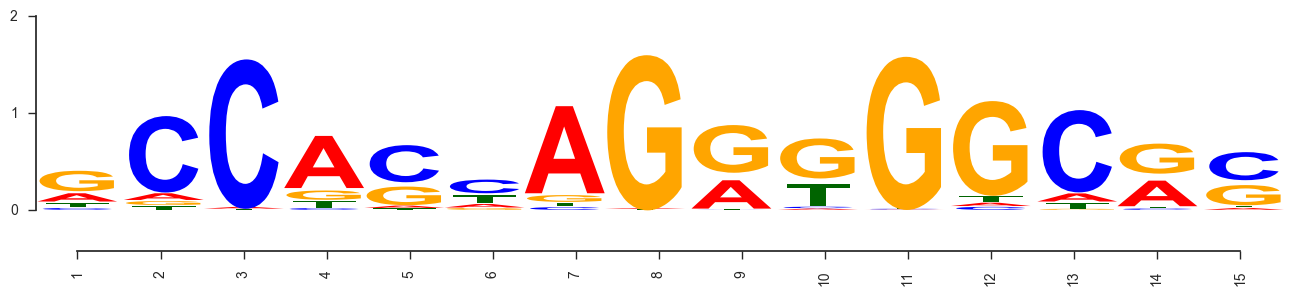

In [91]:
fig = plt.figure()
fig.set_size_inches(len(motif),2.5)
ax = fig.add_subplot(111)
ax.set_xticks(range(len(motif)))

xshift = 0
xticks_t = []
xshifts = [xshift]
trans_offset = transforms.offset_copy(ax.transAxes, 
                                  fig=fig, 
                                  x=0, 
                                  y=0, 
                                  units='points')

xticks_t.append(inv.transform_point((xshift,0))[0])

for i in range(0, len(motif)):
    scores = [(b,rel_info[b][i]) for b in bases]
    scores.sort(key=lambda t: t[1])
    yshift = 0
    for base, score in scores:
        txt = ax.text(0, 
                      0, 
                      base, 
                      transform=trans_offset,
                      fontsize=80, 
                      color=COLOR_SCHEME[base],
                      weight='bold',
                      ha='center',
                      family='sans-serif'
                      )
        txt.set_clip_on(False) 
        txt.set_path_effects([Scale(1.0, score)])
        fig.canvas.draw()
        window_ext = txt.get_window_extent(txt._renderer)
        yshift = window_ext.height*score
        trans_offset = transforms.offset_copy(txt._transform, fig=fig, y=yshift, units='points')
    xshift += window_ext.width
    xshifts.append(xshift)
    inv = ax.transData.inverted()

    trans_offset = transforms.offset_copy(ax.transAxes, fig=fig, x=xshift, units='points')
    xticks_t.append(inv.transform_affine((xshift*2.4, 0))[0])


ax.set_yticks(range(0,3))


seaborn.despine(ax=ax, offset=30, trim=True)
ax.set_xticklabels(range(1,len(motif)+1), rotation=90)
ax.set_yticklabels(np.arange(0,3,1))
plt.show()